In [1]:
import re
from statistics import mean
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
enterup = "enter edit"
#enterup = "enter update"
enterdal = "enter DAL"
exitdal = "exit DAL"
exitup = "exit edit"
#exitup = "exit update"

def get_app_overheads(filename, num_warmup):
    app_send_dur = []
    app_recv_dur = []

    with open(filename) as f:
        tmp = 0
        ctr = 0
        while (line := f.readline()):
            # every four lines is a new run
            ctr += 1
            if ctr <= num_warmup:
                continue
            if (match := re.search(
                "(([0-9]+), \"([a-z]+ [a-zA-Z]+)\", Instant { tv_sec: [0-9]+, tv_nsec: ([0-9]+) })",
                line
            )): 
                run_ct = int(match.group(2))
                level = match.group(3)
                timestamp = int(match.group(4))

                if level == enterup:
                    tmp = timestamp
                elif level == enterdal:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    app_send_dur.append(dur)
                elif level == exitdal:
                    tmp = timestamp
                else:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    app_recv_dur.append(dur)
        print("ctr: ", ctr)
        print("counted: ", ctr - num_warmup)

    return app_send_dur, app_recv_dur

In [3]:
enterpovs = "enter POVS"
entersymenc = "enter SYMENC"
entersessenc = "enter SESSENC"
exitcore = "exit CORE"

def get_core_send_overheads(filename, num_core_send_warmup):
    pov_send_dur = []
    symenc_send_dur = []
    sessenc_send_dur = []

    with open(filename) as f:
        tmp = 0
        ctr = 0
        pov_run = []
        symenc_run = []
        sessenc_run = []
        while (line := f.readline()):
            # every 4 lines is a new message
            ctr += 1
            if ctr <= num_core_send_warmup:
                continue
            if (match := re.search(
                "(([0-9]+), \"([a-z]+ [a-zA-Z]+)\", Instant { tv_sec: [0-9]+, tv_nsec: ([0-9]+) })",
                line
            )):
                run_ct = int(match.group(2))
                level = match.group(3)
                timestamp = int(match.group(4))

                # every 8 lines is a new run
                mod = ctr % 8
                if mod == 0:
                    # pov
                    pov_dur = 0
                    for part in pov_run:
                        pov_dur += part
                    pov_send_dur.append(pov_dur)
                    pov_run = []
                    # sym enc
                    symenc_dur = 0
                    for part in symenc_run:
                        symenc_dur += part
                    symenc_send_dur.append(symenc_dur)
                    symenc_run = []
                    # sess enc
                    sessenc_dur = 0
                    for part in sessenc_run:
                        sessenc_dur += part
                    sessenc_send_dur.append(sessenc_dur)
                    sessenc_run = []

                if level == enterpovs:
                    tmp = timestamp
                elif level == entersymenc:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    pov_run.append(dur)
                    tmp = timestamp
                elif level == entersessenc:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    symenc_run.append(dur)
                    tmp = timestamp
                else:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    sessenc_run.append(dur)
        print("ctr: ", ctr)
        print("counted: ", ctr - num_core_send_warmup)

    return pov_send_dur, symenc_send_dur, sessenc_send_dur

In [4]:
entersessdec = "enter SESSDECR"
entersymdec = "enter SYMDECR"
exitdec = "enter POVS"
exitcore = "exit CORE"

def get_core_recv_overheads(filename, num_core_recv_warmup):
    sessenc_recv_dur = []
    symenc_recv_dur = []
    pov_recv_dur = []

    with open(filename) as f:
        tmp = 0
        ctr = 0
        pov_run = []
        sessenc_run = []
        symenc_run = []
        while (line := f.readline()):
            # every 4 lines is a new message
            ctr += 1
            if ctr <= num_core_recv_warmup:
                continue
            if (match := re.search(
                "(([0-9]+), \"([a-z]+ [a-zA-Z]+)\", Instant { tv_sec: [0-9]+, tv_nsec: ([0-9]+) })",
                line
            )):
                run_ct = int(match.group(2))
                level = match.group(3)
                timestamp = int(match.group(4))

                # every 8 lines is a new run
                mod = ctr % 8
                if mod == 0:
                    # pov
                    pov_dur = 0
                    for part in pov_run:
                        pov_dur += part
                    pov_recv_dur.append(pov_dur)
                    pov_run = []
                    # sym enc
                    symenc_dur = 0
                    for part in symenc_run:
                        symenc_dur += part
                    symenc_recv_dur.append(symenc_dur)
                    symenc_run = []
                    # sess enc
                    sessenc_dur = 0
                    for part in sessenc_run:
                        sessenc_dur += part
                    sessenc_recv_dur.append(sessenc_dur)
                    sessenc_run = []
            
                if level == entersessdec:
                    tmp = timestamp
                elif level == entersymdec:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    sessenc_run.append(dur)
                    tmp = timestamp
                elif level == exitdec:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    symenc_run.append(dur)
                    tmp = timestamp
                else:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    pov_run.append(dur)
        print("ctr: ", ctr)
        print("counted: ", ctr - num_core_recv_warmup)

    return sessenc_recv_dur, symenc_recv_dur, pov_recv_dur

In [5]:
enter_send_dal = "enter sendDAL"
entercore = "enter CORE"
exitcore = "exit CORE"
exit_last_core = "exit LASTCORE"
exit_send_dal = "exit sendDAL"

def get_dal_send_overheads(filename, num_dal_send_warmup):
    dal_send_dur = []
    with open(filename) as f:
        tmp = 0
        ctr = 0
        run = []
        while (line := f.readline()):
            ctr += 1
            if ctr <= num_dal_send_warmup:
                continue
            if (match := re.search(
                "(([0-9]+), \"([a-z]+ [a-zA-Z]+)\", Instant { tv_sec: [0-9]+, tv_nsec: ([0-9]+) })",
                line
            )):
                run_ct = int(match.group(2))
                level = match.group(3)
                timestamp = int(match.group(4))

                # every 6 lines is a new run
                mod = ctr % 6
                if mod == 0:
                    dur = 0
                    for part in run:
                        dur += part
                    dal_send_dur.append(dur)
                    run = []

                if level == enter_send_dal:
                    tmp = timestamp
                elif level == entercore:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    run.append(dur)
                elif level == exitcore:
                    tmp = timestamp
                elif level == exit_last_core:
                    tmp = timestamp
                else:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    run.append(dur)
        print("ctr: ", ctr)
        print("counted: ", ctr - num_dal_send_warmup)

    return dal_send_dur

In [6]:
enter_recv_dal = "enter recvDAL"
exit_recv_dal = "exit recvDAL"

def get_dal_recv_overheads(filename_update, filename_dummy, num_dal_recv_warmup):
    dal_recv_dur_update = []
    with open(filename_update) as f:
        tmp = 0
        ctr = 0
        while (line := f.readline()):
            ctr += 1
            if ctr <= num_dal_recv_warmup:
                continue
            if (match := re.search(
                "(([0-9]+), \"([a-z]+ [a-zA-Z]+)\", Instant { tv_sec: [0-9]+, tv_nsec: ([0-9]+) })",
                line
            )):
                run_ct = int(match.group(2))
                level = match.group(3)
                timestamp = int(match.group(4))

                if level == enter_recv_dal:
                    tmp = timestamp
                else:
                    dur = timestamp - tmp;
                    if dur < 0:
                        dur += 1000000000
                    dal_recv_dur_update.append(dur)

    dal_recv_dur_dummy = []
    with open(filename_dummy) as f:
        tmp = 0
        ctr = 0
        while (line := f.readline()):
            ctr += 1
            if ctr <= num_dal_recv_warmup:
                continue
            if (match := re.search(
                "(([0-9]+), \"([a-z]+ [a-zA-Z]+)\", Instant { tv_sec: [0-9]+, tv_nsec: ([0-9]+) })",
                line
            )):
                run_ct = int(match.group(2))
                level = match.group(3)
                timestamp = int(match.group(4))
                
                if level == enter_recv_dal:
                    tmp = timestamp
                else:
                    dur = timestamp - tmp;
                    if dur < 0:
                        dur += 1000000000
                    dal_recv_dur_dummy.append(dur)

    print(len(dal_recv_dur_update))
    print(len(dal_recv_dur_dummy))

    sum_dal_recv_dur = []
    for (update_dur, dummy_dur) in zip(dal_recv_dur_update, dal_recv_dur_dummy):
        sum_dal_recv_dur.append(update_dur + dummy_dur)

    return sum_dal_recv_dur

In [7]:
#subdir = "/update_pass_output"
subdir = "/edit_post_output"

def app_filename(num_clients, num_runs):
    return ".{}/{}c_{}r_ts_app.txt".format(subdir, num_clients, num_runs)

def dal_send_filename(num_clients, num_runs):
    return ".{}/{}c_{}r_ts_dal_send.txt".format(subdir, num_clients, num_runs)

def dal_recv_filename_update(num_clients, num_runs):
    return ".{}/{}c_{}r_ts_dal_recv_update.txt".format(subdir, num_clients, num_runs)

def dal_recv_filename_dummy(num_clients, num_runs):
    return ".{}/{}c_{}r_ts_dal_recv_dummy.txt".format(subdir, num_clients, num_runs)

def core_send_filename(num_clients, num_runs):
    return ".{}/{}c_{}r_ts_core_send.txt".format(subdir, num_clients, num_runs)

def core_recv_filename(num_clients, num_runs):
    return ".{}/{}c_{}r_ts_core_recv.txt".format(subdir, num_clients, num_runs)


In [8]:
warmup_count = 1000
runs_count = 10000
clients_count = 4

app_send_dur_0, app_recv_dur_0 = get_app_overheads(app_filename(clients_count, runs_count), 4 * warmup_count)
dal_send_dur_0 = get_dal_send_overheads(dal_send_filename(clients_count, runs_count), 6 * warmup_count)
dal_recv_dur_0 = get_dal_recv_overheads(dal_recv_filename_update(clients_count, runs_count), dal_recv_filename_dummy(clients_count, runs_count), 2 * warmup_count)
pov_send_dur_0, symenc_send_dur_0, sessenc_send_dur_0 = get_core_send_overheads(core_send_filename(clients_count, runs_count), 4 * 2 * warmup_count)
sessenc_recv_dur_0, symenc_recv_dur_0, pov_recv_dur_0 = get_core_recv_overheads(core_recv_filename(clients_count, runs_count), 4 * 2 * warmup_count)

ctr:  44000
counted:  40000
ctr:  66000
counted:  60000
10000
10000
ctr:  88000
counted:  80000
ctr:  88000
counted:  80000


In [9]:
print(mean(symenc_send_dur_0))
print(mean(sessenc_send_dur_0))
print(mean(pov_send_dur_0))
print(mean(dal_send_dur_0))
print(mean(app_send_dur_0))

55608.9887
176585.6499
39857.6162
21362.265
10921.6652


<function matplotlib.pyplot.show(close=None, block=None)>

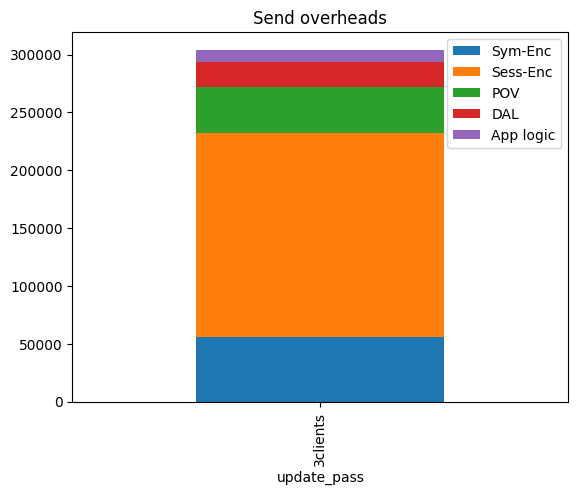

In [10]:
df = pd.DataFrame([
    ["3clients", mean(symenc_send_dur_0), mean(sessenc_send_dur_0), mean(pov_send_dur_0), mean(dal_send_dur_0), mean(app_send_dur_0)],
], columns=["update_pass", "Sym-Enc", "Sess-Enc", "POV", "DAL", "App logic"])
df.plot(x='update_pass', kind='bar', stacked=True, title='Send overheads')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

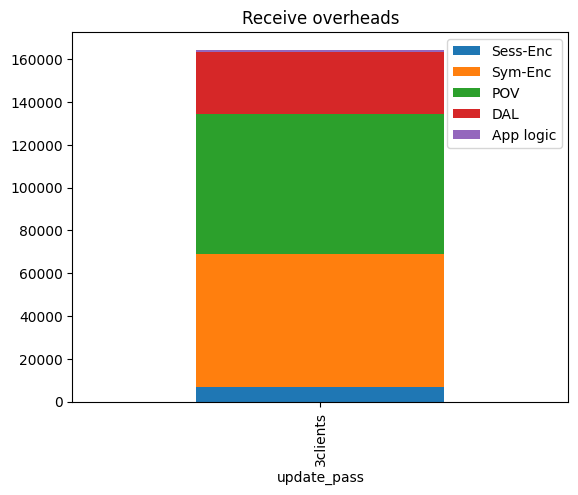

In [11]:
df = pd.DataFrame([
    ["3clients", mean(sessenc_recv_dur_0), mean(symenc_recv_dur_0), mean(pov_recv_dur_0), mean(dal_recv_dur_0), mean(app_recv_dur_0)],
], columns=["update_pass", "Sess-Enc", "Sym-Enc", "POV", "DAL", "App logic"])
df.plot(x='update_pass', kind='bar', stacked=True, title='Receive overheads')
plt.show

In [12]:
warmup_count = 1000
runs_count = 10000
clients_count = 1

app_send_dur_0, app_recv_dur_0 = get_app_overheads(app_filename(clients_count, runs_count), 4 * warmup_count)
dal_send_dur_0 = get_dal_send_overheads(dal_send_filename(clients_count, runs_count), 6 * warmup_count)
dal_recv_dur_0 = get_dal_recv_overheads(dal_recv_filename_update(clients_count, runs_count), dal_recv_filename_dummy(clients_count, runs_count), 2 * warmup_count)
pov_send_dur_0, symenc_send_dur_0, sessenc_send_dur_0 = get_core_send_overheads(core_send_filename(clients_count, runs_count), 4 * 2 * warmup_count)
sessenc_recv_dur_0, symenc_recv_dur_0, pov_recv_dur_0 = get_core_recv_overheads(core_recv_filename(clients_count, runs_count), 4 * 2 * warmup_count)

ctr:  44000
counted:  40000
ctr:  66000
counted:  60000
10000
10000
ctr:  88000
counted:  80000
ctr:  88000
counted:  80000


In [13]:
warmup_count = 1000
runs_count = 10000
clients_count = 2

app_send_dur_1, app_recv_dur_1 = get_app_overheads(app_filename(clients_count, runs_count), 4 * warmup_count)
dal_send_dur_1 = get_dal_send_overheads(dal_send_filename(clients_count, runs_count), 6 * warmup_count)
dal_recv_dur_1 = get_dal_recv_overheads(dal_recv_filename_update(clients_count, runs_count), dal_recv_filename_dummy(clients_count, runs_count), 2 * warmup_count)
pov_send_dur_1, symenc_send_dur_1, sessenc_send_dur_1 = get_core_send_overheads(core_send_filename(clients_count, runs_count), 4 * 2 * warmup_count)
sessenc_recv_dur_1, symenc_recv_dur_1, pov_recv_dur_1 = get_core_recv_overheads(core_recv_filename(clients_count, runs_count), 4 * 2 * warmup_count)

ctr:  44000
counted:  40000
ctr:  66000
counted:  60000
10000
10000
ctr:  88000
counted:  80000
ctr:  88000
counted:  80000


In [14]:
warmup_count = 1000
runs_count = 10000
clients_count = 4

app_send_dur_2, app_recv_dur_2 = get_app_overheads(app_filename(clients_count, runs_count), 4 * warmup_count)
dal_send_dur_2 = get_dal_send_overheads(dal_send_filename(clients_count, runs_count), 6 * warmup_count)
dal_recv_dur_2 = get_dal_recv_overheads(dal_recv_filename_update(clients_count, runs_count), dal_recv_filename_dummy(clients_count, runs_count), 2 * warmup_count)
pov_send_dur_2, symenc_send_dur_2, sessenc_send_dur_2 = get_core_send_overheads(core_send_filename(clients_count, runs_count), 4 * 2 * warmup_count)
sessenc_recv_dur_2, symenc_recv_dur_2, pov_recv_dur_2 = get_core_recv_overheads(core_recv_filename(clients_count, runs_count), 4 * 2 * warmup_count)

ctr:  44000
counted:  40000
ctr:  66000
counted:  60000
10000
10000
ctr:  88000
counted:  80000
ctr:  88000
counted:  80000


In [15]:
warmup_count = 1000
runs_count = 10000
clients_count = 8

app_send_dur_4, app_recv_dur_4 = get_app_overheads(app_filename(clients_count, runs_count), 4 * warmup_count)
dal_send_dur_4 = get_dal_send_overheads(dal_send_filename(clients_count, runs_count), 6 * warmup_count)
dal_recv_dur_4 = get_dal_recv_overheads(dal_recv_filename_update(clients_count, runs_count), dal_recv_filename_dummy(clients_count, runs_count), 2 * warmup_count)
pov_send_dur_4, symenc_send_dur_4, sessenc_send_dur_4 = get_core_send_overheads(core_send_filename(clients_count, runs_count), 4 * 2 * warmup_count)
sessenc_recv_dur_4, symenc_recv_dur_4, pov_recv_dur_4 = get_core_recv_overheads(core_recv_filename(clients_count, runs_count), 4 * 2 * warmup_count)

ctr:  44000
counted:  40000
ctr:  66000
counted:  60000
10000
10000
ctr:  88000
counted:  80000
ctr:  88000
counted:  80000


In [16]:
warmup_count = 1000
runs_count = 10000
clients_count = 16

app_send_dur_5, app_recv_dur_5 = get_app_overheads(app_filename(clients_count, runs_count), 4 * warmup_count)
dal_send_dur_5 = get_dal_send_overheads(dal_send_filename(clients_count, runs_count), 6 * warmup_count)
dal_recv_dur_5 = get_dal_recv_overheads(dal_recv_filename_update(clients_count, runs_count), dal_recv_filename_dummy(clients_count, runs_count), 2 * warmup_count)
pov_send_dur_5, symenc_send_dur_5, sessenc_send_dur_5 = get_core_send_overheads(core_send_filename(clients_count, runs_count), 4 * 2 * warmup_count)
sessenc_recv_dur_5, symenc_recv_dur_5, pov_recv_dur_5 = get_core_recv_overheads(core_recv_filename(clients_count, runs_count), 4 * 2 * warmup_count)

ctr:  44000
counted:  40000
ctr:  66000
counted:  60000
10000
10000
ctr:  88000
counted:  80000
ctr:  88000
counted:  80000


In [17]:
warmup_count = 1000
runs_count = 10000
clients_count = 32

app_send_dur_6, app_recv_dur_6 = get_app_overheads(app_filename(clients_count, runs_count), 4 * warmup_count)
dal_send_dur_6 = get_dal_send_overheads(dal_send_filename(clients_count, runs_count), 6 * warmup_count)
dal_recv_dur_6 = get_dal_recv_overheads(dal_recv_filename_update(clients_count, runs_count), dal_recv_filename_dummy(clients_count, runs_count), 2 * warmup_count)
pov_send_dur_6, symenc_send_dur_6, sessenc_send_dur_6 = get_core_send_overheads(core_send_filename(clients_count, runs_count), 4 * 2 * warmup_count)
sessenc_recv_dur_6, symenc_recv_dur_6, pov_recv_dur_6 = get_core_recv_overheads(core_recv_filename(clients_count, runs_count), 4 * 2 * warmup_count)

ctr:  44000
counted:  40000
ctr:  66000
counted:  60000
10000
10000
ctr:  88000
counted:  80000
ctr:  88000
counted:  80000


In [18]:
ratio = 1000

symencsend_ms_0 = mean(symenc_send_dur_0) / ratio
symencsend_ms_1 = mean(symenc_send_dur_1) / ratio
symencsend_ms_2 = mean(symenc_send_dur_2) / ratio
symencsend_ms_4 = mean(symenc_send_dur_4) / ratio
symencsend_ms_5 = mean(symenc_send_dur_5) / ratio
symencsend_ms_6 = mean(symenc_send_dur_6) / ratio

encsend_ms_0 = mean(sessenc_send_dur_0) / ratio
encsend_ms_1 = mean(sessenc_send_dur_1) / ratio
encsend_ms_2 = mean(sessenc_send_dur_2) / ratio
encsend_ms_4 = mean(sessenc_send_dur_4) / ratio
encsend_ms_5 = mean(sessenc_send_dur_5) / ratio
encsend_ms_6 = mean(sessenc_send_dur_6) / ratio

povsend_ms_0 = mean(pov_send_dur_0) / ratio
povsend_ms_1 = mean(pov_send_dur_1) / ratio
povsend_ms_2 = mean(pov_send_dur_2) / ratio
povsend_ms_4 = mean(pov_send_dur_4) / ratio
povsend_ms_5 = mean(pov_send_dur_5) / ratio
povsend_ms_6 = mean(pov_send_dur_6) / ratio

dalsend_ms_0 = mean(dal_send_dur_0) / ratio
dalsend_ms_1 = mean(dal_send_dur_1) / ratio
dalsend_ms_2 = mean(dal_send_dur_2) / ratio
dalsend_ms_4 = mean(dal_send_dur_4) / ratio
dalsend_ms_5 = mean(dal_send_dur_5) / ratio
dalsend_ms_6 = mean(dal_send_dur_6) / ratio

appsend_ms_0 = mean(app_send_dur_0) / ratio
appsend_ms_1 = mean(app_send_dur_1) / ratio
appsend_ms_2 = mean(app_send_dur_2) / ratio
appsend_ms_4 = mean(app_send_dur_4) / ratio
appsend_ms_5 = mean(app_send_dur_5) / ratio
appsend_ms_6 = mean(app_send_dur_6) / ratio

sum0 = symencsend_ms_0 + encsend_ms_0 + povsend_ms_0 + dalsend_ms_0 + appsend_ms_0
sum1 = symencsend_ms_1 + encsend_ms_1 + povsend_ms_1 + dalsend_ms_1 + appsend_ms_1
sum2 = symencsend_ms_2 + encsend_ms_2 + povsend_ms_2 + dalsend_ms_2 + appsend_ms_2
sum4 = symencsend_ms_4 + encsend_ms_4 + povsend_ms_4 + dalsend_ms_4 + appsend_ms_4
sum5 = symencsend_ms_5 + encsend_ms_5 + povsend_ms_5 + dalsend_ms_5 + appsend_ms_5
sum6 = symencsend_ms_6 + encsend_ms_6 + povsend_ms_6 + dalsend_ms_6 + appsend_ms_6

max_send = max(sum0, sum1, sum2, sum4, sum5, sum6)
max_send

1961.3118451000003

In [19]:
f = open("send_means_edit_post.txt", "a")

f.write("Label\tsymenc\tsessenc\tpov\tdal\tapp\n")
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(1, symencsend_ms_0, encsend_ms_0, povsend_ms_0, dalsend_ms_0, appsend_ms_0))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(2, symencsend_ms_1, encsend_ms_1, povsend_ms_1, dalsend_ms_1, appsend_ms_1))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(4, symencsend_ms_2, encsend_ms_2, povsend_ms_2, dalsend_ms_2, appsend_ms_2))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(8, symencsend_ms_4, encsend_ms_4, povsend_ms_4, dalsend_ms_4, appsend_ms_4))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(16, symencsend_ms_5, encsend_ms_5, povsend_ms_5, dalsend_ms_5, appsend_ms_5))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(32, symencsend_ms_6, encsend_ms_6, povsend_ms_6, dalsend_ms_6, appsend_ms_6))
f.close()

In [20]:
encsend_ms_0 = mean(sessenc_recv_dur_0) / ratio
encsend_ms_1 = mean(sessenc_recv_dur_1) / ratio
encsend_ms_2 = mean(sessenc_recv_dur_2) / ratio
encsend_ms_4 = mean(sessenc_recv_dur_4) / ratio
encsend_ms_5 = mean(sessenc_recv_dur_5) / ratio
encsend_ms_6 = mean(sessenc_recv_dur_6) / ratio

symencsend_ms_0 = mean(symenc_recv_dur_0) / ratio
symencsend_ms_1 = mean(symenc_recv_dur_1) / ratio
symencsend_ms_2 = mean(symenc_recv_dur_2) / ratio
symencsend_ms_4 = mean(symenc_recv_dur_4) / ratio
symencsend_ms_5 = mean(symenc_recv_dur_5) / ratio
symencsend_ms_6 = mean(symenc_recv_dur_6) / ratio

povsend_ms_0 = mean(pov_recv_dur_0) / ratio
povsend_ms_1 = mean(pov_recv_dur_1) / ratio
povsend_ms_2 = mean(pov_recv_dur_2) / ratio
povsend_ms_4 = mean(pov_recv_dur_4) / ratio
povsend_ms_5 = mean(pov_recv_dur_5) / ratio
povsend_ms_6 = mean(pov_recv_dur_6) / ratio

dalsend_ms_0 = mean(dal_recv_dur_0) / ratio
dalsend_ms_1 = mean(dal_recv_dur_1) / ratio
dalsend_ms_2 = mean(dal_recv_dur_2) / ratio
dalsend_ms_4 = mean(dal_recv_dur_4) / ratio
dalsend_ms_5 = mean(dal_recv_dur_5) / ratio
dalsend_ms_6 = mean(dal_recv_dur_6) / ratio

appsend_ms_0 = mean(app_recv_dur_0) / ratio
appsend_ms_1 = mean(app_recv_dur_1) / ratio
appsend_ms_2 = mean(app_recv_dur_2) / ratio
appsend_ms_4 = mean(app_recv_dur_4) / ratio
appsend_ms_5 = mean(app_recv_dur_5) / ratio
appsend_ms_6 = mean(app_recv_dur_6) / ratio

sum0 = symencsend_ms_0 + encsend_ms_0 + povsend_ms_0 + dalsend_ms_0 + appsend_ms_0
sum1 = symencsend_ms_1 + encsend_ms_1 + povsend_ms_1 + dalsend_ms_1 + appsend_ms_1
sum2 = symencsend_ms_2 + encsend_ms_2 + povsend_ms_2 + dalsend_ms_2 + appsend_ms_2
sum4 = symencsend_ms_4 + encsend_ms_4 + povsend_ms_4 + dalsend_ms_4 + appsend_ms_4
sum5 = symencsend_ms_5 + encsend_ms_5 + povsend_ms_5 + dalsend_ms_5 + appsend_ms_5
sum6 = symencsend_ms_6 + encsend_ms_6 + povsend_ms_6 + dalsend_ms_6 + appsend_ms_6

max_send = max(sum0, sum1, sum2, sum4, sum5, sum6)
max_send

1259.6552077

In [21]:
f = open("recv_means_edit_post.txt", "a")

f.write("Label\tsymenc\tsessenc\tpov\tdal\tapp\n")
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(1, symencsend_ms_0, encsend_ms_0, povsend_ms_0, dalsend_ms_0, appsend_ms_0))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(2, symencsend_ms_1, encsend_ms_1, povsend_ms_1, dalsend_ms_1, appsend_ms_1))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(4, symencsend_ms_2, encsend_ms_2, povsend_ms_2, dalsend_ms_2, appsend_ms_2))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(8, symencsend_ms_4, encsend_ms_4, povsend_ms_4, dalsend_ms_4, appsend_ms_4))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(16, symencsend_ms_5, encsend_ms_5, povsend_ms_5, dalsend_ms_5, appsend_ms_5))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(32, symencsend_ms_6, encsend_ms_6, povsend_ms_6, dalsend_ms_6, appsend_ms_6))
f.close()

<function matplotlib.pyplot.show(close=None, block=None)>

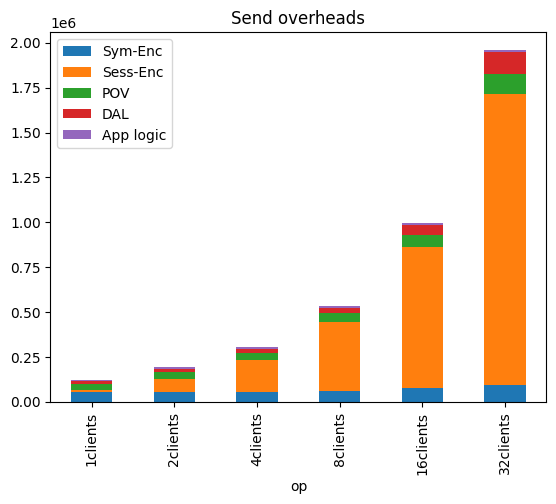

In [22]:
df = pd.DataFrame([
    ["1clients", mean(symenc_send_dur_0), mean(sessenc_send_dur_0), mean(pov_send_dur_0), mean(dal_send_dur_0), mean(app_send_dur_0)],
    ["2clients", mean(symenc_send_dur_1), mean(sessenc_send_dur_1), mean(pov_send_dur_1), mean(dal_send_dur_1), mean(app_send_dur_1)],
    ["4clients", mean(symenc_send_dur_2), mean(sessenc_send_dur_2), mean(pov_send_dur_2), mean(dal_send_dur_2), mean(app_send_dur_2)],
    ["8clients", mean(symenc_send_dur_4), mean(sessenc_send_dur_4), mean(pov_send_dur_4), mean(dal_send_dur_4), mean(app_send_dur_4)],
    ["16clients", mean(symenc_send_dur_5), mean(sessenc_send_dur_5), mean(pov_send_dur_5), mean(dal_send_dur_5), mean(app_send_dur_5)],
    ["32clients", mean(symenc_send_dur_6), mean(sessenc_send_dur_6), mean(pov_send_dur_6), mean(dal_send_dur_6), mean(app_send_dur_6)],
], columns=["op", "Sym-Enc", "Sess-Enc", "POV", "DAL", "App logic"])
df.plot(x='op', kind='bar', stacked=True, title='Send overheads')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

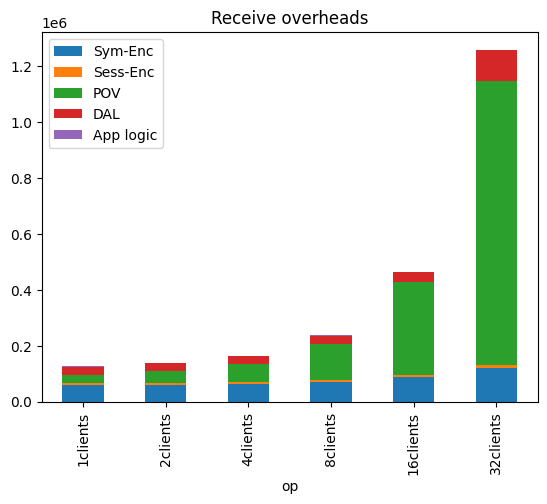

In [23]:
df = pd.DataFrame([
    ["1clients", mean(symenc_recv_dur_0), mean(sessenc_recv_dur_0), mean(pov_recv_dur_0), mean(dal_recv_dur_0), mean(app_recv_dur_0)],
    ["2clients", mean(symenc_recv_dur_1), mean(sessenc_recv_dur_1), mean(pov_recv_dur_1), mean(dal_recv_dur_1), mean(app_recv_dur_1)],
    ["4clients", mean(symenc_recv_dur_2), mean(sessenc_recv_dur_2), mean(pov_recv_dur_2), mean(dal_recv_dur_2), mean(app_recv_dur_2)],
    ["8clients", mean(symenc_recv_dur_4), mean(sessenc_recv_dur_4), mean(pov_recv_dur_4), mean(dal_recv_dur_4), mean(app_recv_dur_4)],
    ["16clients", mean(symenc_recv_dur_5), mean(sessenc_recv_dur_5), mean(pov_recv_dur_5), mean(dal_recv_dur_5), mean(app_recv_dur_5)],
    ["32clients", mean(symenc_recv_dur_6), mean(sessenc_recv_dur_6), mean(pov_recv_dur_6), mean(dal_recv_dur_6), mean(app_recv_dur_6)],
], columns=["op", "Sym-Enc", "Sess-Enc", "POV", "DAL", "App logic"])
df.plot(x='op', kind='bar', stacked=True, title='Receive overheads')
plt.show